# Efficient topology optimization in MATLAB using 88 lines of code

Este cuaderno está basado en (1).

In [1]:
using Plots
using LinearAlgebra
using SparseArrays
using Statistics

**Problema de optimización topológica**

$$ min_{\boldsymbol{x}} c(\boldsymbol{x}) = U^{T}K U = \sum_{e=1}^{N} E_{e}(x_{e} ) u_{e}^{T} k_{0} u_{e}$$
sujeto a $V(\boldsymbol{x})/V_0 = f$, $KU=F$, $\boldsymbol{0}\leq\boldsymbol{x}\leq\boldsymbol{1}$, donde:
- $E_{e} = E_{min} + x_{e}^{p}(E_0 - E_{min})$ es el módulo de Young.
- $U$ es el vector de desplazamiento global.
- $F$ es el vector global de fuerzas externas.
- $k_0$ es la matriz de rigidez para un elemento con módulo de Young unitario.
- $\boldsymbol{x}$ es el vector de variables de diseño.
- $N$ es el número de elementos para discretizar el dominio.
- $V(\boldsymbol{x})$ y $V_0$ son el volumen del material y el volumen dominio de diseño.
- $f$ es la fracción de volumen preescrita.

**Método de criterios de optimización**

Para cada elemento $e$ la variable de diseño $x_{e}$ es actualizada a $x_{e}^{new}$ siguiendo el siguiente esquema:

$$x_{e}^{new} = \left\{\begin{array}{cc}
max(0,x_{e}-m)& \text{si } x_{e}B^{\eta}_{e}\leq max(0,x_{e}-m)\\
min(1,x_{e}+m)& \text{si } x_{e}B^{\eta}_{e}\geq min(1,x_{e}+m)\\
x_{e}B^{\eta}_{e} & \text{en otro caso.}
\end{array}\right.$$

donde $\eta=1/2$ es un coeficiente de amortiguación numérico, y $B_{e}$ es obtnido de la condición de optimalidad,

$$B_{e} = \frac{-\frac{\partial c}{\partial x_{e}}}{\lambda \frac{\partial V}{\partial x_{e}}}$$

donde $\lambda$ es el multiplicador de Lagrange, este valor debe ser escogido de tal manera que la restricción de volumen debe satisfacerse; el valor apropiado se encuentra por medio del método de bisección. La sensibilidad de la función objetivo $c$ y del volumen del material $V$ respecto a la densidad del elemento $x_{e}$ son dadas por:


$$ \frac{\partial c}{\partial x_{e}} = -p x_{e}^{p-1} (E_{0}-E_{min}) u_{e}^{T}k_{0}u_{e}$$

$$\frac{\partial V}{\partial  x_{e}} = 1$$

La última ecuación se deduce de que cada elemento tiene volumen unitario.


**Filtrado**

El filtro de sensibilidad modifica las sensibilidades $\frac{\partial c}{\partial x_{e}}$ de la siguiente manera

$$\hat{\frac{\partial c}{\partial x_{e}}} = \frac{1}{max(\gamma,x_{e}) \sum_{i\in N{e}}H_{ei}} \sum_{i\in N{e}}H_{ei}x_{i}\frac{\partial c}{\partial x_{i}}$$

donde:

- $N_{e}$ es el conjunto de elementos $i$ que están a una distancia $\Delta(e,i)$ del elemento $e$ menor a $r_{min}$

**Función `top88`**
1. `nelx`: Es un entero que representa el número de elementos finitos en la dirección x.
2. `nely`: Es un entero que representa el número de elementos finitos en la dirección y.
3. `volfrac`: Es un número flotante que indica el volumen fraccional deseado en la topología optimizada.
4. `penal`: Es un número flotante que se utiliza en el cálculo de la penalización para suavizar la función objetivo.
5. `rmin`: Es un número flotante que se utiliza como radio mínimo para el filtro.
6. `ft`: Es un entero que indica el tipo de filtro utilizado en el proceso de optimización.

Estos parámetros se pasan a la función `top88` para controlar diversos aspectos del proceso de optimización topológica.


In [2]:
nelx = 60
nely = 20
volfrac = 0.5
penal = 3
rmin = 1.5
ft = 1

1

**Propiedades del material**

1. `E0`: Es el módulo de elasticidad del material en su estado no penalizado. Representa la rigidez del material en su forma original. Este parámetro afecta la rigidez estructural del diseño final.

2. `Emin`: Es el módulo de elasticidad mínimo permitido para evitar que los elementos tengan una rigidez excesivamente baja. Es esencialmente un límite inferior en el módulo de elasticidad. Emin se utiliza para suavizar la función objetivo y evitar la aparición de elementos con una rigidez demasiado baja.

3. `nu`: Es el coeficiente de Poisson, que representa la relación entre las deformaciones transversales y longitudinales de un material cuando se aplica una carga. Se utiliza en el cálculo del tensor de elasticidad para tener en cuenta el comportamiento del material bajo carga.

Estas constantes influyen en el comportamiento y la calidad del diseño obtenido mediante la optimización topológica.

In [3]:
# MATERIAL PROPERTIES
E0 = 1
Emin = 1e-9
nu = 0.3

0.3

**Preparación del análisis de elementos finitos**
1. $A_{11} = \left(\begin{array}{cccc}
12 & 3 & -6 & -3\\
3 & 12 & 3 & 0 \\
-6 & 3 & 12 & -3\\
-3 & 0 & -3 & 12
\end{array}\right)$


2.   $A_{12} = \left(\begin{array}{cccc}
-6 & 3 & 0 & 3\\
-3 & -6 & -3 & -6 \\
0 & -3 & -6 & 3\\
3 & -6 & 3 & -6
\end{array}\right)$

3. $B_{11} = \left(\begin{array}{cccc}
-4 & 3 & -2 & 9\\
3 & -4 & -9 & 4 \\
-2 & -9 & -4 & -3\\
9 & 4 & -3 & -4
\end{array}\right)$


4. $B_{12} = \left(\begin{array}{cccc}
2 & -3 & 4 & -9\\
-3 & 2 & 9 & -2 \\
4 & 9 & 2 & 3\\
-9 & -2 & 3 & 2
\end{array}\right)$

5. $KE = \frac{1}{24(1- \nu ^2)}\left(\begin{array}{c|c}
A_{11} & A_{12}  \\ \hline
A_{12}^T & A_{11}  \\
\end{array}\right) + \nu \left(\begin{array}{c|c}
B_{11} & B_{12}  \\ \hline
B_{12}^T & B_{11}  \\
\end{array}\right) $

6. **`nodenrs`:** Esta variable (matriz) se utiliza para asignar números de nodo a los nodos de la malla de elementos finitos. En este código, `nodenrs` se genera mediante la función `reshape` en la línea 13. La forma de `nodenrs` será una matriz con `(nelx + 1) * (nely + 1)` filas y una columna.

7. **`edofVec`:** Esta variable (vector) representa el vector de grados de libertad (DOF) para cada elemento finito. Es una lista de los DOF asociados con cada nodo de cada elemento finito. La forma de `edofVec` será una matriz con `nelx * nely` filas y una columna. Los DOF se enumeran en este vector de manera que cada fila corresponde a un elemento finito y contiene los índices de los DOF asociados con ese elemento.

8. **`edofMat`:** Esta variable es una matriz que indica cómo se ensamblan los grados de libertad (DOF) de los elementos finitos en la matriz global de rigidez. La forma de `edofMat` es una matriz con `nelx * nely` filas y 8 columnas, donde cada fila corresponde a un elemento finito y cada columna contiene el índice de un DOF asociado con ese elemento. Las primeras cuatro columnas de `edofMat` representan los DOF de desplazamiento en $x$ e $y$ para los cuatro nodos del elemento, y las últimas cuatro columnas representan los DOF de desplazamiento en $x$ e $y$ para los cuatro nodos de la esquina del elemento.
9. `iK`: Contiene las coordenadas de fila de los elementos no nulos en la matriz `K`. Estas coordenadas están relacionadas con los DOF de los nodos de los elementos finitos.
10. `jK`: Contiene las coordenadas de columna de los elementos no nulos en la matriz `K`. Al igual que `iK`, estas coordenadas también están relacionadas con los DOF de los nodos de los elementos finitos.

Los vectores resultantes $iK$ y $jK$ están estructurados de manera que los índices $iK(k)$ y $jK(k)$ corresponden a la entrada $(i, j)$-ésima de la matriz de rigidez para el elemento $e$, donde $k = i + 8(j - 1) + 64(e - 1)$.

In [4]:
# PREPARE FINITE ELEMENT ANALYSIS
A11 = [12 3 -6 -3; 3 12 3 0; -6 3 12 -3; -3 0 -3 12]
A12 = [-6 -3 0 3; -3 -6 -3 -6; 0 -3 -6 3; 3 -6 3 -6]
B11 = [-4 3 -2 9; 3 -4 -9 4; -2 -9 -4 -3; 9 4 -3 -4]
B12 = [2 -3 4 -9; -3 2 9 -2; 4 9 2 3; -9 -2 3 2]

# 8x8 MATRIX
KE = 1/(1-nu^2)/24 * ([A11 A12; A12' A11] + nu * [B11 B12; B12' B11])

nodenrs = reshape(collect(1:(1+nelx)*(1+nely)), (1+nely, 1+nelx))
edofVec = reshape(2*nodenrs[1:end-1, 1:end-1] .+ 1, nelx*nely, 1)
edofMat = repeat(edofVec, 1, 8) .+ repeat([0 1 2*nely+2 2*nely+3 2*nely+0 2*nely+1 -2 -1], nelx*nely,1)

iK = reshape(transpose(kron(edofMat, ones(8,1))), 64*nelx*nely, 1)
jK = reshape(transpose(kron(edofMat, ones(1,8))), 64*nelx*nely, 1);

**Definir cargas y soportes (mitad viga-MBB)**

1. `F`: Este es un vector de tamaño `2*(nely+1)*(nelx+1)` que se inicializa como un vector de ceros y al nodo $(1,0)$ se le asigna el valor $-1$. Este vector representa las fuerzas aplicadas a los nodos del sistema.
2. `U`: `U` se inicializa como un vector de ceros con una longitud igual al número total de grados de libertad en el sistema de elementos finitos. Cada elemento de `U` corresponde a un grado de libertad particular y representa el desplazamiento en esa dirección para el nodo asociado. Como el tamaño de `U`es de `2*(nely+1)*(nelx+1)` el modelo tiene dos grados de libertad por nodo que representa los desplazamientos en $x$ e $y$.
3. `fixeddofs`: Índices de los grados de libertad de frontera.
4. `alldofs`: Todos los índices de los grados de libertad.
5. `freedofs`: Índices de los grados de libertad en el interior.

In [5]:
# DEFINE LOADS AND SUPPORTS (HALF MBB-BEAM)
F = zeros(2*(nely+1)*(nelx+1), 1)
F[2,1] = -1
U = zeros(size(F))
fixeddofs = union(1:2:2*(nely+1), [2*(nelx+1)*(nely+1)])
alldofs = 1:2*(nely+1)*(nelx+1)
freedofs = setdiff(alldofs, fixeddofs);

**Preparación de filtro**

1. `iH`: Índices de las filas de la matriz `H`.
2. `jH`: Índices de las columnas de la matriz `H`.
3. `sH`: Valores de las entradas de la matriz `H` en la posición determinada por cada entrada de `iH` y `jH`. Los valores de este vector corresponden a valores de sensibilidad de los vecinos de cada elemento
4. `k`: Índice que modifica `iH`, `jH` y `sH`. El valor máximo de este índice depende del valor de `rmin`.
5. `H`: Esta matriz se construye como un matriz esparsa usando `iH`,`jH` y `sH`; la dimensión de esta matriz es de `(nelx*nely*(2*(ceil(rmin)-1)+1)^2`. La matriz `H` se utiliza para "promediar" la sensibilidad de la función objetivo en un vecindario de cada elemento. Esto ayuda a eliminar pequeñas estructuras irregulares y a obtener diseños con características más robustas y de mayor tamaño. Nótese que para cada elemento `e1`, habrá `(2*(ceil(rmin)-1)+1)^2` elementos vecinos.
6. `Hs`: Este es un vector que contiene la suma por filas de la matriz `H`. Este vector se utiliza para normalizar cada fila de la matriz `H`. Tal normalización asegura que la suma de los pesos de cada elemento en la operación de filtrado sea igual a 1. La normalización con `Hs` evita sesgos en la operación de filtrado y asegura que la sensibilidad de cada elemento se vea afectada de manera uniforme por sus vecinos.


Los ciclos *for* anidados realizan lo siguiente:

Ciclo exterior (líneas 30-33):
- Recorre cada elemento `e1` en la malla.

Ciclo interior (líneas 34-41):
- Para cada elemento `e1`, recorre los elementos vecinos `e2` dentro del radio de filtro rmin.
- Se calcula la distancia entre `e1` y `e2`.
- Si la distancia está dentro del radio `rmin`, se calcula un valor de filtro `sH` basado en la distancia.
- Se añaden los índices de `e1` y `e2` a las matrices `iH` y `jH`, respectivamente.
- Se añade el valor `sH` a la matriz `Hs`. 

In [6]:
# PREPARE FILTER
iH = ones(Int(nelx*nely*(2*(ceil(rmin)-1)+1)^2)) #25
jH = ones(size(iH)) #26
sH = zeros(size(iH)) #27

k = 0 #28
for i1 = 1:nelx #29
    for j1 = 1:nely #30 
        e1 = (i1-1)*nely+j1 #31
        for i2 = max(i1-(ceil(rmin)-1),1):min(i1+(ceil(rmin)-1),nelx) #32
            for j2 = max(j1-(ceil(rmin)-1),1):min(j1+(ceil(rmin)-1),nely) #33
                e2 = (i2-1)*nely+j2 #34
                k += 1 #35
                iH[k] = e1 #36
                jH[k] = e2 #37
                sH[k] = max(0,rmin-sqrt((i1-i2)^2+(j1-j2)^2)) #38
            end #39
        end #40
    end #41
end #42

H = sparse(iH, jH, sH) #43
Hs = sum(H, dims=2); #44

**Inicialización de iteracion**

Las líneas 46 a 49 se encargan de inicializar las variables de diseño y densidad física.
1. `x`: Se crea una matriz `x` con el valor `volfrac` (fracción de volumen) para cada elemento. Esto representa la densidad de diseño inicial.
2. `xPhys`: Se crea una matriz `xPhys` con el mismo tamaño que `x`. Se utiliza para almacenar la densidad física que se utiliza en el análisis por elementos finitos (FEA).
3. `loop`: Contador de iteraciones.
4. `change`: Variable que controla la convergencia del algoritmo.

In [7]:
# INITIALIZE ITERATION
x = fill(volfrac, nely, nelx) #46
xPhys = copy(x) #47 
loop = 0 #48
change = 1 #49

1

**Comienzo de iteración**

**Análisis de elementos finitos** (líneas 54 a 56)
1. `sK`: La matriz de rigidez elemental `KE` se escala por la densidad elemental `xPhys` para obtener `sK`. En este caso, esta variable se representa como un vector de tamaño `64*nelx*nely`.
2. `K`: Se calcula la matriz de rigidez global K a partir de la densidad física actual xPhys y las propiedades del material.
3. `U`: Se aplica la fuerza F al sistema y se resuelve el sistema de ecuaciones lineales para obtener los desplazamientos U. Recuerdese que,

$$K U = F$$


**Función objetivo y análisis de sensibilidad**
1. `ce`: Se calcula la energía de deformación (compliance) ce a partir de los desplazamientos `U`.
2. `c`: Se calcula la función objetivo `c` como la suma de la energía de deformación `ce` y un término de penalización que regulariza la densidad.
3. `dc`: Se calcula la sensibilidad `dc` de la función objetivo con respecto a la densidad de diseño `x`.
4. `dv`: Esta variable representa la actualización de la densidad de diseño en cada iteración.


**Modificación de sensibilidades**
Se aplica un filtro a la sensibilidad dc para eliminar las estructuras irregulares y promover características de tamaño mínimo. La elección del filtro depende del tipo de optimización que se desea realizar (por ejemplo, optimización de estructuras, optimización de fluidos).


**Actualización de criterio óptimo de las variables de diseño y las densidades físicas**
1. `l1`:
2. `l2`:
3. `move`:
4. `xnew`: Se actualiza la densidad física xPhys para el siguiente análisis por elementos finitos (FEA). El cálculo se hace de la siguiente manera:

$$x_{new,i} = \left\{\begin{array}{cc}
x_i \sqrt{\frac{-dc_{i}}{dv_{i}l_{mid}}} & \text{si } max(0, x_{i}-move) \leq x_i \sqrt{\frac{-dc_{i}}{dv_{i}l_{mid}}} \leq min(x_{i}+move ,1)
\end{array}\right.$$

La idea es que cada entrada de `xnew` este en $[0,1]$, que el cambio respecto a cada entrada de `x` sea menor a `move` y que a su vez dependa de la sensibilidad de la función objetivo en esta instancia.

5. `lmid`: Se utiliza un método de búsqueda de línea para encontrar un valor de paso lmid que garantice que la densidad de diseño actualizada satisfaga la restricción de volumen.
6. `change`: Es la norma del máximo entre `xnew` y `x`, o sea, $change = ||x_{new}-x||_{\infty}$.

Luego de aplicar el filtro se actualiza la densidad de diseño x utilizando la sensibilidad filtrada dc y el valor de paso lmid.
Si el cambio es menor que un valor de tolerancia, el algoritmo converge y se detiene.

**Imprimir resultados**

Se imprime información sobre la iteración actual, la función objetivo, el volumen y el cambio en la densidad. Finalmente, se visualiza la densidad de diseño actual.

In [15]:
nelx*nely*4

4800

In [13]:
sK = reshape(KE[:] * (Emin .+ xPhys[:]'.^penal .* (E0 - Emin)), 64*nelx*nely) #54 
K = sparse(reshape(Int.(iK),64*nelx*nely), reshape(Int.(jK),64*nelx*nely), reshape(sK,64*nelx*nely)); #55
K

2562×2562 SparseMatrixCSC{Float64, Int64} with 44164 stored entries:
⎡⢿⣷⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎤
⎢⠀⠙⢿⣷⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠙⢿⣷⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠙⢿⣷⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠙⢿⣷⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢿⣷⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢿⣷⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢿⣷⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢿⣷⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢿⣷⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢿⣷⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢿⣷⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢿⣷⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢿⣷⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢿⣷⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢿⣷⣄⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢿⣷⣄⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢿⣷⣄⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢿⣷⣄⠀⎥
⎣⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢿⣷⎦

In [8]:
# START ITERATION
while change > 0.01 #51
    loop += 1 #52
    
    # FE-ANALYSIS
    sK = reshape(KE[:] * (Emin .+ xPhys[:]'.^penal .* (E0 - Emin)), 64*nelx*nely) #54 
    K = sparse(reshape(Int.(iK),64*nelx*nely), reshape(Int.(jK),64*nelx*nely), reshape(sK,64*nelx*nely)) #55
    K = (K + K') / 2 #55
    U[freedofs] .= K[freedofs, freedofs] \ F[freedofs] #56
    
    # OBJECTIVE FUNCTION AND SENSITIVITY ANALYSIS
    ce = reshape(sum((U[edofMat] * KE) .* U[edofMat], dims=2), nely, nelx)
    c = sum(sum((Emin .+ xPhys.^penal .* (E0 - Emin)) .* ce))
    dc = -penal * (E0 - Emin) .* xPhys.^(penal - 1) .* ce
    dv = ones(nely, nelx)
    
    # FILTERING/MODIFICATION OF SENSITIVITIES
    if ft == 1
        dc[:] = H * (x[:] .* dc[:]) ./ Hs ./ max.(1e-3, x[:])
    elseif ft == 2
        dc[:] = H * (dc[:] ./ Hs)
        dv[:] = H * (dv[:] ./ Hs)
    end
    
    # OPTIMALITY CRITERIA UPDATE OF DESIGN VARIABLES AND PHYSICAL DENSITIES
    l1 = 0
    l2 = 1e9
    move = 0.2
    xnew = 0
    while (l2 - l1) / (l1 + l2) > 1e-3
        lmid = 0.5 * (l2 + l1)
        xnew = max.(0, max.(x .- move, min.(1, min.(x .+ move, x .* sqrt.(-dc ./ dv ./ lmid)))))
        if ft == 1
            xPhys .= xnew
        elseif ft == 2
            xPhys[:] = (H * xnew[:]) ./ Hs
        end
        if sum(xPhys[:]) > volfrac * nelx * nely
            l1 = lmid
        else
            l2 = lmid
        end
    end
    
    change = maximum(abs.(xnew[:] .- x[:]))
    x .= xnew
    
    # PRINT RESULTS
    println("Iteration: ", loop, " Obj: ", c, " Vol: ", mean(xPhys[:]), " ch: ", change)
end

Iteration: 1 Obj: 1007.0221007117705 Vol: 0.5000571635537224 ch: 0.2
Iteration: 2 Obj: 579.4186935348803 Vol: 0.5000251573537363 ch: 0.20000000000000007
Iteration: 3 Obj: 412.45632408226504 Vol: 0.5001605461968425 ch: 0.20000000000000007
Iteration: 4 Obj: 343.71618504738416 Vol: 0.4999971529795974 ch: 0.20000000000000007
Iteration: 5 Obj: 322.0470310831915 Vol: 0.49979300580016267 ch: 0.1931510610516548
Iteration: 6 Obj: 308.7133434731954 Vol: 0.5002467145396782 ch: 0.20000000000000007
Iteration: 7 Obj: 298.1992805205498 Vol: 0.5002376639600025 ch: 0.17020682434885426
Iteration: 8 Obj: 288.7821750967294 Vol: 0.5002692862025911 ch: 0.1912016657614387
Iteration: 9 Obj: 280.32941887606 Vol: 0.4997244124282736 ch: 0.13228110480048838
Iteration: 10 Obj: 272.88883418866794 Vol: 0.4998260466586807 ch: 0.12944961745932548
Iteration: 11 Obj: 265.4777324948374 Vol: 0.4999816821643536 ch: 0.16076315316809708
Iteration: 12 Obj: 257.27060440394456 Vol: 0.5000720307479615 ch: 0.16733086459002888
Ite

**Graficar densidades**

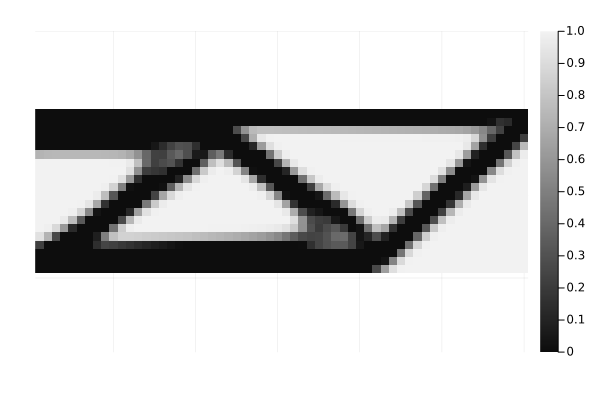

In [9]:
# Graficar la matriz de densidades 1-xPhys
heatmap(1 .- xPhys, c=:grays, clim=(0, 1), aspect_ratio=:equal, axis=false)

# Referencias

1. Andreassen, E., Clausen, A., Schevenels, M., Lazarov, B. S., & Sigmund, O. (2011). Efficient topology optimization in MATLAB using 88 lines of code. Structural and Multidisciplinary Optimization, 43(1), 1-16. https://doi.org/10.1007/s00158-010-0594-7